# This notebook is about the few models I tried and how they performed 
You can simply run all cells, the functions have not been so well documented but I'm guessing you'll understand it as you see it.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# tree based classifier
import xgboost as xgb
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model.ridge import RidgeClassifier 
from sklearn.gaussian_process.gpc import GaussianProcessClassifier

# ensemble classifiers
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.ensemble.forest import ExtraTreesClassifier
from sklearn.ensemble.forest import RandomForestClassifier

# linear classifiers
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_val_score, cross_validate

from sklearn.preprocessing import StandardScaler


In [2]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.metrics import sensitivity_specificity_support, geometric_mean_score, classification_report_imbalanced
from imblearn.pipeline import Pipeline, make_pipeline

In [3]:
import seaborn as sns

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
from scipy.stats import spearmanr, pearsonr

In [6]:
from collections import Counter
import os
import sys

In [7]:
base_dir = sys.path[0][:sys.path[0].rindex('\\')+1] 
binary_file = base_dir + r"\feature_files\new_glcm(binary).csv"
multiclass_file = base_dir + r"\feature_files\new_glcm(multiclass).csv"

In [8]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']

In [9]:
b_df = pd.read_csv(binary_file)
m_df = pd.read_csv(multiclass_file)

In [10]:
def pipeline_prediction(X, y, model, sampler=None, plot_confusion_matrix=False, filename=None):
    
    pipe = Pipeline([('scaler', StandardScaler()), ('sampler', sampler), ('model', model)])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
    
    print(f"Before sampling: {Counter(y_train)}") 

    pipe.fit(X_train, y_train)

    get_metrics(y_true=y_test, y_pred=pipe.predict(X_test), plot_confusion_matrix=plot_confusion_matrix, file_name=filename)
    
    # return pipeline for direct prediction, skipping the details
    # receive the piepline and can call `get_metrics()` normally
    return pipe
    

In [11]:
def get_metrics(y_true, y_pred, y_score=None, file_name=None, plot_confusion_matrix=False):
    
    print(f'Accuracy: {accuracy_score(y_true=y_true, y_pred=y_pred)}')
   
    print(classification_report_imbalanced(y_true=y_true, y_pred=y_pred))
    
    if y_score is not None:
        print(f"Roc-auc-score: {roc_auc_score(y_pred, y_score=y_score)}")
        plot_roc_curve(y_true=y_true, y_proba=y_score, n_classes=len(np.unique(y_true)))
    
    labels = ['True Neg','False Pos','False Neg','True Pos']
    
    if plot_confusion_matrix:
        if len(np.unique(y_true)) > 2:
            categories = ['Zero', 'One', 'Two']
        else:
            categories = ['Zero', 'One']

        cf_matrix = confusion_matrix(y_true, y_pred)
        make_confusion_matrix(cf_matrix, 
                              group_names=labels,
                              categories=categories, 
                              cmap='Blues', fig_name=file_name)


In [12]:
# Taken from: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          fig_name=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns_plot = sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        
    if fig_name:
        figure = sns_plot.get_figure()
        figure.savefig(fig_name)
        
        print(f"Saved: {fig_name}")

# *Binary Classification tests*

In [13]:
b_df.head()

,name,contrast,dissimilarity,homogeneity,correlation,energy,label
0,DSC_0100_Brown spot_10_binary.npy,64.003665,0.250995,0.999016,0.953311,0.988906,0
1,DSC_0100_Brown spot_11_binary.npy,73.536126,0.288377,0.998869,0.951997,0.987579,0
2,DSC_0100_Brown spot_12_binary.npy,58.556545,0.229634,0.999099,0.954353,0.989632,0
3,DSC_0100_Brown spot_13_binary.npy,59.918325,0.234974,0.999079,0.954955,0.989254,0
4,DSC_0100_Brown spot_14_binary.npy,61.280105,0.240314,0.999058,0.956024,0.988751,0


In [14]:
b_df.head()

,name,contrast,dissimilarity,homogeneity,correlation,energy,label
0,DSC_0100_Brown spot_10_binary.npy,64.003665,0.250995,0.999016,0.953311,0.988906,0
1,DSC_0100_Brown spot_11_binary.npy,73.536126,0.288377,0.998869,0.951997,0.987579,0
2,DSC_0100_Brown spot_12_binary.npy,58.556545,0.229634,0.999099,0.954353,0.989632,0
3,DSC_0100_Brown spot_13_binary.npy,59.918325,0.234974,0.999079,0.954955,0.989254,0
4,DSC_0100_Brown spot_14_binary.npy,61.280105,0.240314,0.999058,0.956024,0.988751,0


In [15]:
b_df = b_df.sample(frac=1).reset_index(drop=True)

In [16]:
b_df.head(20)

,name,contrast,dissimilarity,homogeneity,correlation,energy,label
0,DSC_0108_Brown spot_39_binary.npy,53.179399,0.389629,0.983991,0.951927,0.980667,0
1,DSC_0328_Leaf smut_50_binary.npy,7.730635,0.062645,0.996229,0.969242,0.994226,1
2,DSC_0391_Brown spot_29_binary.npy,5.716901,0.070664,0.991464,0.986840,0.985810,0
3,DSC_0307_Brown spot_61_binary.npy,6.250458,0.061393,0.994153,0.983273,0.990813,1
4,DSC_0118_Brown spot_28_binary.npy,20.739529,0.252834,0.989310,0.911277,0.985112,1
5,DSC_0506_Leaf smut_69_binary.npy,39.789972,0.161602,0.998474,0.953052,0.992864,0
6,DSC_0314_Leaf smut_37_binary.npy,10.159777,0.068873,0.994291,0.991796,0.986578,1
7,DSC_0702_Bacterial leaf blight_41_binary.npy,2.488482,0.045639,0.992882,0.989907,0.988732,1
8,DSC_0332_Brown spot_76_binary.npy,12.844529,0.063282,0.996522,0.987481,0.990101,0
9,DSC_0321_Leaf smut_77_binary.npy,7.866147,0.037667,0.997852,0.992422,0.990463,0


In [17]:
b_df['label'].value_counts()

0    6943
1    2481
Name: label, dtype: int64

In [18]:
X = b_df.iloc[:, 1:-1].values
y = b_df['label'].values

In [19]:
lr = LogisticRegression()
sampler = SMOTETomek()

res = pipeline_prediction(X, y, model=lr, sampler=sampler)

Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.670096463022508
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.68      0.65      0.75      0.66      0.44      2291
          1       0.42      0.65      0.68      0.51      0.66      0.44       819

avg / total       0.73      0.67      0.66      0.69      0.66      0.44      3110



In [20]:
lr = LogisticRegression(class_weight='balanced')


In [21]:
_ = pipeline_prediction(X, y, lr)

Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.67491961414791
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.69      0.64      0.76      0.66      0.44      2291
          1       0.42      0.64      0.69      0.51      0.66      0.44       819

avg / total       0.73      0.67      0.65      0.69      0.66      0.44      3110




#### Note: I have used `.sample(frac=1)` to shuffle each Dataframe.

In [22]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 6943, 1: 2481})


In [23]:
sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)

In [24]:
print('Oversampled dataset shape %s' % Counter(y_res))

Oversampled dataset shape Counter({0: 6943, 1: 6943})


#### `SMOTE + LogisticRegression(class_weight='balanced')` results the same as in `SMOTE + LogisticRegression()`   

In [25]:
?DecisionTreeClassifier

Init signature:
DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    presort='deprecated',
    ccp_alpha=0.0,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information gain.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None
    The maximum depth of the tree. If None, then nodes are ex

In [26]:
dt = DecisionTreeClassifier(criterion='entropy', splitter='best')

In [27]:
_ = pipeline_prediction(X, y, model=dt, sampler=SMOTETomek())

Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.6459807073954984
                   pre       rec       spe        f1       geo       iba       sup

          0       0.80      0.70      0.50      0.74      0.59      0.36      2291
          1       0.37      0.50      0.70      0.43      0.59      0.34       819

avg / total       0.68      0.65      0.55      0.66      0.59      0.35      3110



In [28]:
dt = DecisionTreeClassifier(criterion='entropy', splitter='best', class_weight='balanced')


In [29]:
_ = pipeline_prediction(X, y, model=dt, sampler=SMOTETomek())

Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.6530546623794212
                   pre       rec       spe        f1       geo       iba       sup

          0       0.79      0.72      0.47      0.75      0.58      0.35      2291
          1       0.37      0.47      0.72      0.42      0.58      0.33       819

avg / total       0.68      0.65      0.54      0.66      0.58      0.34      3110



In [30]:
knn = KNeighborsClassifier(weights='distance')

In [31]:
_ = pipeline_prediction(X, y, model=knn, sampler=SMOTE())

Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.6437299035369775
                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.66      0.60      0.73      0.63      0.40      2291
          1       0.39      0.60      0.66      0.47      0.63      0.39       819

avg / total       0.71      0.64      0.62      0.66      0.63      0.40      3110



# Now let's try `Bagging`

In [32]:

dt_bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, n_jobs=10)


In [33]:
_ = pipeline_prediction(X, y, model=dt_bag, sampler=SMOTETomek())

Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.684887459807074
                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.75      0.52      0.78      0.62      0.39      2291
          1       0.42      0.52      0.75      0.46      0.62      0.38       819

avg / total       0.71      0.68      0.58      0.69      0.62      0.39      3110



Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.6890675241157557
                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.75      0.53      0.78      0.63      0.40      2291
          1       0.43      0.53      0.75      0.47      0.63      0.39       819

avg / total       0.71      0.69      0.59      0.70      0.63      0.40      3110

Saved: rf.jpg


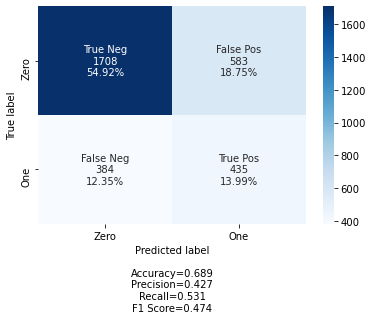

In [34]:
model = RandomForestClassifier()
sampler = SMOTETomek()

_ = pipeline_prediction(X, y, model=model, sampler=sampler, plot_confusion_matrix=True, filename="rf.jpg")

## Boosting ⚡🔥

In [35]:
model = xgb.XGBClassifier()
sampler = SMOTETomek()

_ = pipeline_prediction(X, y, model=model, sampler=sampler)

Before sampling: Counter({0: 4652, 1: 1662})
Accuracy: 0.6463022508038585
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.63      0.69      0.72      0.66      0.43      2291
          1       0.40      0.69      0.63      0.51      0.66      0.44       819

avg / total       0.73      0.65      0.68      0.67      0.66      0.43      3110



# *Multi-class Classification*

In [36]:
m_df.head()

,name,contrast,dissimilarity,homogeneity,correlation,energy,label
0,DSC_0100_Brown spot_34_multiclass.npy,84.081099,0.337665,0.998142,0.948118,0.986702,1
1,DSC_0100_Brown spot_35_multiclass.npy,53.901455,0.222576,0.998778,0.956402,0.989780,1
2,DSC_0100_Brown spot_43_multiclass.npy,71.474377,0.288838,0.998007,0.954366,0.987098,1
3,DSC_0100_Brown spot_45_multiclass.npy,22.443047,0.236387,0.985251,0.978301,0.981649,1
4,DSC_0100_Brown spot_46_multiclass.npy,39.486052,0.294555,0.986651,0.961464,0.983676,1


In [37]:
m_df.drop(m_df.columns[0], axis=1, inplace=True)

In [38]:
m_df.head()

,contrast,dissimilarity,homogeneity,correlation,energy,label
0,84.081099,0.337665,0.998142,0.948118,0.986702,1
1,53.901455,0.222576,0.998778,0.956402,0.989780,1
2,71.474377,0.288838,0.998007,0.954366,0.987098,1
3,22.443047,0.236387,0.985251,0.978301,0.981649,1
4,39.486052,0.294555,0.986651,0.961464,0.983676,1


In [39]:
m_df = m_df.sample(frac=1).reset_index(drop=True)

In [40]:
m_df.head(20)

,contrast,dissimilarity,homogeneity,correlation,energy,label
0,1.044509,0.029529,0.995701,0.988620,0.993948,0
1,9.853501,0.071550,0.994246,0.990710,0.987829,2
2,5.504736,0.088752,0.992615,0.960006,0.990072,2
3,7.921987,0.096622,0.987851,0.987344,0.981185,1
4,15.723529,0.078129,0.995269,0.987019,0.988440,2
5,45.192709,0.390997,0.980721,0.956316,0.974992,2
6,16.300695,0.092370,0.994059,0.986036,0.986224,2
7,21.941752,0.118154,0.993659,0.984666,0.983966,0
8,53.544818,0.518707,0.985351,0.876622,0.983294,1
9,17.793253,0.360049,0.980630,0.910071,0.978057,2


In [41]:
X = m_df.iloc[:, :-1]
y = m_df['label']

In [42]:
model = xgb.XGBClassifier()
sampler = SMOTETomek()

_ = pipeline_prediction(X, y, model=model, sampler=sampler)

Before sampling: Counter({2: 747, 1: 510, 0: 405})
Accuracy: 0.6471306471306472
                   pre       rec       spe        f1       geo       iba       sup

          0       0.56      0.75      0.81      0.64      0.78      0.61       199
          1       0.66      0.64      0.85      0.65      0.74      0.54       251
          2       0.71      0.59      0.80      0.65      0.69      0.47       369

avg / total       0.66      0.65      0.82      0.65      0.73      0.52       819



In [43]:
model = ExtraTreesClassifier()
sampler = SMOTETomek()

_ = pipeline_prediction(X, y, model=model, sampler=sampler)

Before sampling: Counter({2: 747, 1: 510, 0: 405})
Accuracy: 0.6605616605616605
                   pre       rec       spe        f1       geo       iba       sup

          0       0.61      0.71      0.85      0.66      0.78      0.60       199
          1       0.67      0.61      0.87      0.64      0.73      0.51       251
          2       0.69      0.67      0.75      0.68      0.71      0.50       369

avg / total       0.66      0.66      0.81      0.66      0.73      0.53       819



In [44]:
model = AdaBoostClassifier()
sampler = ADASYN()

_ = pipeline_prediction(X, y, model=model, sampler=sampler)

Before sampling: Counter({2: 747, 1: 510, 0: 405})
Accuracy: 0.5433455433455433
                   pre       rec       spe        f1       geo       iba       sup

          0       0.51      0.77      0.76      0.62      0.77      0.59       199
          1       0.51      0.66      0.72      0.58      0.69      0.47       251
          2       0.64      0.34      0.84      0.44      0.53      0.27       369

avg / total       0.57      0.54      0.79      0.53      0.64      0.41       819



Before sampling: Counter({2: 747, 1: 510, 0: 405})
Accuracy: 0.6617826617826618
                   pre       rec       spe        f1       geo       iba       sup

          0       0.59      0.76      0.83      0.67      0.80      0.63       199
          1       0.67      0.62      0.86      0.64      0.73      0.52       251
          2       0.71      0.63      0.79      0.67      0.71      0.49       369

avg / total       0.67      0.66      0.82      0.66      0.74      0.54       819

Saved: rf_mul.jpg


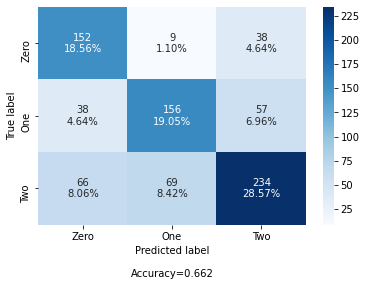

In [45]:
model = RandomForestClassifier()
sampler = SMOTETomek()

_ = pipeline_prediction(X, y, model=model, sampler=sampler, plot_confusion_matrix=True, filename="rf_mul.jpg")